In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
train = pd.read_csv('train.csv')

# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [34]:
def extract_keypoints():
    frame_number = 0
    frame = []
    type_ = []
    index = []
    x = []
    y = []
    z = []
    cap = cv2.VideoCapture(0)
    #cap.set(cv2.CAP_PROP_FPS, fps)
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break
            frame_number += 1
            if frame_number > 30:
                break
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, dsize=None, fx=4, fy=4)
            results = holistic.process(image)
            draw_styled_landmarks(image, results)
            #face
            if(results.face_landmarks is None):
                for i in range(468):
                    frame.append(frame_number)
                    type_.append("face")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.face_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("face")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #pose
            if(results.pose_landmarks is None):
                for i in range(33):
                    frame.append(frame_number)
                    type_.append("pose")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.pose_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("pose")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #left hand
            if(results.left_hand_landmarks is None):
                for i in range(21):
                    frame.append(frame_number)
                    type_.append("left_hand")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.left_hand_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("left_hand")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #right hand
            if(results.right_hand_landmarks is None):
                for i in range(21):
                    frame.append(frame_number)
                    type_.append("right_hand")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.right_hand_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("right_hand")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)

            cv2.imshow('Raw Webcam Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()        
            
    df =  pd.DataFrame({
        "frame" : frame,
        "type"  : type_,
        "landmark_index" : index,
        "x" : x,
        "y" : y,
        "z" : z
    })
    df['y']=df['y']*-1       
    return df

In [8]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pq_path[data_columns]
    print(data)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [35]:
def predict_sign(path):
    demo_raw_data = load_relevant_data_subset(path)
    interpreter = tf.lite.Interpreter("model.tflite")
    found_signatures = list(interpreter.get_signature_list().keys())
    prediction_fn = interpreter.get_signature_runner("serving_default")

    output = prediction_fn(inputs=demo_raw_data)
    plt.bar(range(len(output["outputs"])), output["outputs"])
    sign = output['outputs'].argmax()
    prob  = output["outputs"][sign]
    print("probe : ", prob)
    print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
    #df = train[train['path'].str.contains(path)]
    #print("TRUE : ", df.sign.values[0], f'[{df.sign_ord.values[0]}]')
    return ORD2SIGN.get(sign)

In [36]:
new_sign = extract_keypoints()

In [37]:
new_sign

,frame,type,landmark_index,x,y,z
0,1,face,0,0.498852,-0.491564,-0.017410
1,1,face,1,0.498186,-0.464121,-0.032078
2,1,face,2,0.498571,-0.473054,-0.016684
3,1,face,3,0.492982,-0.438278,-0.023894
4,1,face,4,0.498089,-0.455848,-0.034116
...,...,...,...,...,...,...
16285,30,right_hand,16,0.306751,-0.239736,-0.033740
16286,30,right_hand,17,0.224437,-0.355020,-0.016296
16287,30,right_hand,18,0.238646,-0.309406,-0.026518
16288,30,right_hand,19,0.250061,-0.279841,-0.031920


              x         y         z
0      0.481175  0.519780 -0.036955
1      0.483024  0.479704 -0.064578
2      0.486194  0.489469 -0.034891
3      0.471652  0.449982 -0.045983
4      0.481754  0.470200 -0.068317
...         ...       ...       ...
68956  0.375806  0.530774 -0.031283
68957  0.245619  0.618707 -0.033904
68958  0.266802  0.586477 -0.043138
68959  0.289046  0.566555 -0.043430
68960  0.312514  0.550985 -0.043256

[68961 rows x 3 columns]
probe :  0.7697715
PRED :  pretty [178]


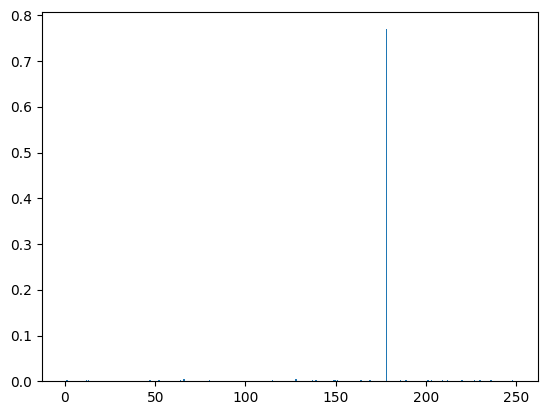

In [40]:
test = pd.read_parquet('1363575346.parquet')
sign = predict_sign(test)

In [41]:
sign

'pretty'

The phrase being shown here is: pretty


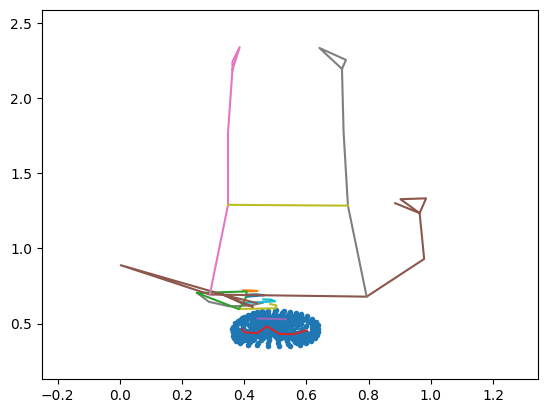

In [45]:
df = test
fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=df.frame.unique())

print(f"The phrase being shown here is: {sign}")
HTML(animation.to_html5_video())

In [17]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x],
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x],
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x],
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y],
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y],
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y],
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]]
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x],
         [pose.iloc[10].x, pose.iloc[9].x],
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x,
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x],
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x],
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x],
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y],
         [pose.iloc[10].y, pose.iloc[9].y],
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y,
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y],
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y],
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y],
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

def animation_frame(f):
    frame = df[df.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ## These values set the limits on the graph to stabilize the video
    xmin = df.x.min() - 0.2
    xmax = df.x.max() + 0.2
    ymin = df.y.min() - 0.2
    ymax = df.y.max() + 0.2
    
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)